In [1]:
from __future__ import print_function
import numpy as np
import math
from pyspark.sql import SparkSession,\
                        functions as func,\
                        DataFrameStatFunctions as statFunc
from pyspark.sql.types import StructType,\
                              StructField,\
                              StringType,\
                              TimestampType,\
                              IntegerType,\
                              DoubleType,\
                              DateType

# are we running on AWS?
ON_AWS = False

# Do you want to output (dataframes and plots) to be displayed?
# If on AWS, choose False. If local, choose True.
AS_JUPYTER = not ON_AWS

# Do you want to write the ouput of the dataframes to your local disk?
# If on AWS, choose True.
WRITE_LOCALLY = ON_AWS

IN_FILE = "" # file to read from
OUT_FILE = "" # folder name to write to
MAX_TO_SHOW = 50 # number of dataframe records to display (if running interactively)

    
def partsOneThroughFive():
    """partsOneThroughFive - Used to run the code to generate the data for parts 1-5.
    :return: None
    """
    ##################
    ###   Setup    ###
    ##################
    spark = SparkSession.builder.appName("A2").getOrCreate()

    schema = StructType([
                StructField("cmte_id", StringType()),
                StructField("cand_id", StringType()),
                StructField("cand_nm", StringType()),
                StructField("contbr_nm", StringType()),
                StructField("contbr_city", StringType()),
                StructField("contbr_st", StringType()),
                StructField("contbr_zip", StringType()),
                StructField("contbr_employer", StringType()),
                StructField("contbr_occupation", StringType()),
                StructField("contb_receipt_amt", DoubleType()),    
                StructField("contb_receipt_dt", StringType()),
                StructField("receipt_desc", StringType()),
                StructField("memo_cd", StringType()),
                StructField("memo_text", StringType()),
                StructField("form_tp", StringType()),
                StructField("file_num", IntegerType()),
                StructField("tran_id", StringType()),
                StructField("election_tp", StringType())
            ])

    candidates_df = spark.read.csv(IN_FILE, header=True, schema=schema)

    # if we cared to do anything with the date ranges, the following would convert it to a usable format
    #date = func.unix_timestamp(func.col('contb_receipt_dt'), 'dd-MMM-yy').cast('timestamp').cast(DateType())
    #candidates_df = candidates_df.withColumn('date',date).drop('contb_receipt_dt')

    candidates_df = candidates_df.filter(func.col('contb_receipt_amt')>0) # remove charge-backs/bounced checks

    ##################
    ### Question 1 ###
    ##################

    candidate_aggr_cnt_amt = candidates_df.groupby("cand_id", "cand_nm")\
                                          .agg(func.count('*')\
                                                   .alias('count'),\
                                               func.sum('contb_receipt_amt')\
                                                   .alias('amount'))


    candidate_aggr_cnt_sorted = candidate_aggr_cnt_amt.sort("count", ascending=False)

    if AS_JUPYTER:
        print("1. How many donations did each candidate have?")
        candidate_aggr_cnt_sorted.selectExpr('cand_nm as Candidate_Name',
                                             'count as Total_Num_Donations')\
                                 .show(n=MAX_TO_SHOW, truncate=False)
    if WRITE_LOCALLY:
        candidate_aggr_cnt_sorted.selectExpr('cand_nm as Candidate_Name',
                                         'count as Total_Num_Donations')\
                                 .write\
                                 .format("csv")\
                                 .mode("overwrite")\
                                 .save(OUT_FILE+"_Q1")

    ##################
    ### Question 2 ###
    ##################

    candidate_aggr_amt_sorted = candidate_aggr_cnt_amt.sort("count", ascending=False)

    if AS_JUPYTER:
        print("2. What was the total amount donated to each candidate?")
        candidate_aggr_amt_sorted.selectExpr('cand_nm',
                                             'amount as Total_Donation_Amount')\
                                 .show(n=MAX_TO_SHOW, truncate=False)
    if WRITE_LOCALLY:
        candidate_aggr_amt_sorted.selectExpr('cand_nm', 'amount as Total_Donation_Amount')\
                                 .write\
                                 .format("csv")\
                                 .mode("overwrite")\
                                 .save(OUT_FILE+"_Q2")

    ##################
    ### Question 3 ###
    ##################

    # grouping by employer and occupation might be slightly off if some people changed professions between donations
    unique_contrib_by_cand = candidates_df.groupby('cand_id',
                                                   'cand_nm', 
                                                   'contbr_nm', 
                                                   'contbr_city', 
                                                   'contbr_st', 
                                                   'contbr_zip', 
                                                   'contbr_employer', 
                                                   'contbr_occupation')\
                                          .agg(func.count('*')
                                                   .alias('num_contributions'))

    num_unique_contbrs = unique_contrib_by_cand.groupby('cand_id', 'cand_nm')\
                                               .agg(func.countDistinct('*')\
                                               .alias('Unique_Donors'))

    num_unique_contbrs_sorted = num_unique_contbrs.sort('Unique_Donors', ascending=False)

    if AS_JUPYTER:
        print("3. How many unique contributors did each candidate have?")
        num_unique_contbrs_sorted.selectExpr('cand_nm as Candidate', 
                                             'Unique_Donors')\
                                 .show(n=MAX_TO_SHOW, truncate=False)
    if WRITE_LOCALLY:
        num_unique_contbrs_sorted.selectExpr('cand_nm as Candidate', 'Unique_Donors')\
                                  .write.format("csv")\
                                  .mode("overwrite")\
                                  .save(OUT_FILE+"_Q3")

    ##################
    ### Question 4 ###
    ##################

    stats_by_cand = candidates_df.groupby("cand_id", "cand_nm")\
                                 .agg(func.mean('contb_receipt_amt')\
                                          .alias('Average_Donation_Amount'),\
                                      func.stddev('contb_receipt_amt')\
                                          .alias('Standard_Dev_Amount'))\
                                 .fillna({'Standard_Dev_Amount':0})

    stats_by_cand_sorted = stats_by_cand.sort('Average_Donation_Amount',ascending=False)


    if AS_JUPYTER:
        print("4. What mean and standard deviation of the donations for each candidate.")
        stats_by_cand_sorted.show(n=MAX_TO_SHOW, truncate=False)

    if WRITE_LOCALLY:
        stats_by_cand_sorted.write\
                            .format("csv")\
                            .mode("overwrite")\
                            .save(OUT_FILE+"_Q4")


    ##################
    ### Question 5 ###
    ##################

    contb_over_50 = candidates_df.where(func.col('contb_receipt_amt') > 50)
    contb_over_50_stats = contb_over_50.groupBy('cand_id', 'cand_nm')\
                                           .agg(func.count('*')\
                                                    .alias('count_over_50'),\
                                                func.sum('contb_receipt_amt')\
                                                    .alias('amount_over_50'))

    contb_under_50 = candidates_df.where(func.col('contb_receipt_amt') <= 50)
    contb_under_50_stats = contb_under_50.groupBy('cand_id', 'cand_nm')\
                                         .agg(func.count('*')\
                                                  .alias('count_under_50'),\
                                              func.sum('contb_receipt_amt')\
                                                  .alias('amount_under_50'))

    cand_over_under = contb_over_50_stats.join(contb_under_50_stats, ['cand_id', 'cand_nm'])

    cand_over_under_cnt = cand_over_under.withColumn('total_count',
                                                     func.col('count_over_50')+func.col('count_under_50'))
    cand_over_under_cnt_amt = cand_over_under_cnt.withColumn('total_amount',
                                                             func.col('amount_over_50')+func.col('amount_under_50'))

    pct_under_cnt = cand_over_under_cnt_amt.withColumn('Pct_under_50_count', 
                                                       100*func.col('count_under_50')/func.col('total_count'))
    pct_under_over_cnt = pct_under_cnt.withColumn('Pct_over_50_count',
                                                  100*func.col('count_over_50')/func.col('total_count'))

    pct_under_over_cnt_amt = pct_under_over_cnt.withColumn('Pct_under_50_amount',
                                                           100*func.col('amount_under_50')/func.col('total_amount'))
    pct_under_over_cnt_amt = pct_under_over_cnt_amt.withColumn('Pct_over_50_amount', 
                                                               100*func.col('amount_over_50')/func.col('total_amount'))


    if AS_JUPYTER:
        print("5. What percentage of the each campaign’s donations was done by small contributors, that is donations under $50?")
        pct_under_over_cnt_amt.select('cand_nm', pct_under_over_cnt_amt.colRegex("`Pct.+`")).show(n=MAX_TO_SHOW, truncate=False)

    if WRITE_LOCALLY:
        pct_under_over_cnt_amt.select('cand_nm', pct_under_over_cnt_amt.colRegex("`Pct.+`"))\
                              .write\
                              .format("csv")\
                              .mode("overwrite")\
                              .save(OUT_FILE+"_Q5")

def files_from_args():
    """files_from_args - Used to parse command line arguments. Accepts input filename and output filename.
    :return: (input filename, output filename)
    """
    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument('-i', '--input', default='input')
    parser.add_argument('-o', '--output',default='output')
    args = parser.parse_args()
    return (args.input, args.output)
        
if __name__ == "__main__":
    if AS_JUPYTER:
        IN_FILE, OUT_FILE = ("P00000001-ALL.csv", "local_output")
    else:
        IN_FILE, OUT_FILE = files_from_args()
    partsOneThroughFive()

1. How many donations did each candidate have?
+--------------------------+-------------------+
|Candidate_Name            |Total_Num_Donations|
+--------------------------+-------------------+
|Trump, Donald J.          |6561784            |
|Biden, Joseph R Jr        |6310247            |
|Sanders, Bernard          |2542911            |
|Warren, Elizabeth         |823958             |
|Buttigieg, Pete           |601732             |
|Yang, Andrew              |358546             |
|Klobuchar, Amy J.         |184706             |
|Harris, Kamala D.         |176902             |
|O’Rourke, Robert Beto     |95821              |
|Booker, Cory A.           |80872              |
|Gabbard, Tulsi            |80579              |
|Williamson, Marianne      |43224              |
|Castro, Julián            |35592              |
|Bennet, Michael F.        |24823              |
|Bullock, Steve            |14461              |
|Inslee, Jay R             |13049              |
|Gillibrand, Kirsten  

In [2]:
from __future__ import print_function
import numpy as np
import math
from pyspark.sql import SparkSession,\
                        functions as func,\
                        DataFrameStatFunctions as statFunc
from pyspark.sql.types import StructType,\
                              StructField,\
                              StringType,\
                              TimestampType,\
                              IntegerType,\
                              DoubleType,\
                              DateType

# are we running on AWS?
ON_AWS = False

# Do you want to output (dataframes and plots) to be displayed?
# If on AWS, choose False. If local, choose True.
AS_JUPYTER = not ON_AWS

# Do you want to write the ouput of the dataframes to your local disk?
# If on AWS, choose True.
WRITE_LOCALLY = ON_AWS

IN_FILE = "" # file to read from
OUT_FILE = "" # folder name to write to

def getDistribution(cand_data, bucket_list):
    """getDistribution - Used to bucket the contribution amounts based on the bucket_list amounts. For
                            example, bucket_list=[0, 5, 10, 15] will count the number of contributions
                            in each of the following groups:
                            (0 <= contribution < 5), (5 <= contribution < 10), and (10 <= contributions <= 15)
    :param cand_data: Dataframe of one candidate containing a column "contb_receipt_amt" with the
                        dollar amount of each contribution to this candidate.
    :param bucket_list: Precomputed bins (ascending and nonrepeating) corresponding to our data.
    :return: list of the bins inputted as well as a list of the counts per bin.
    """
    bins, counts = cand_data.select(func.col("contb_receipt_amt")).rdd.flatMap(lambda x:x).histogram(bucket_list)
    return (bins, counts)
    
def partSix():
    """partSix - Used to run the code to generate the data for the first half of part 6.
    :return: None
    """
    ##################
    ###   Setup    ###
    ##################
    spark = SparkSession.builder.appName("A2").getOrCreate()

    schema = StructType([
                StructField("cmte_id", StringType()),
                StructField("cand_id", StringType()),
                StructField("cand_nm", StringType()),
                StructField("contbr_nm", StringType()),
                StructField("contbr_city", StringType()),
                StructField("contbr_st", StringType()),
                StructField("contbr_zip", StringType()),
                StructField("contbr_employer", StringType()),
                StructField("contbr_occupation", StringType()),
                StructField("contb_receipt_amt", DoubleType()),    
                StructField("contb_receipt_dt", StringType()),
                StructField("receipt_desc", StringType()),
                StructField("memo_cd", StringType()),
                StructField("memo_text", StringType()),
                StructField("form_tp", StringType()),
                StructField("file_num", IntegerType()),
                StructField("tran_id", StringType()),
                StructField("election_tp", StringType())
            ])

    candidates_df = spark.read.csv(IN_FILE, header=True, schema=schema)

    ##################
    ### Question 6 ###
    ##################

    trump = 'Trump, Donald J.'
    biden = 'Biden, Joseph R Jr'

    # make easier to reference dataframes
    trump_biden_data = candidates_df.filter((func.col('cand_nm')==trump) | (func.col('cand_nm')==biden))
    trump_data = candidates_df.filter(func.col('cand_nm')==trump)
    biden_data = candidates_df.filter(func.col('cand_nm')==biden)

    max_contb_amt_df = trump_biden_data.select('contb_receipt_amt').agg(func.max('contb_receipt_amt'))
    max_contb_amt = math.ceil(float(max_contb_amt_df.first()[0]))

    # create the bins for the contribution distribution
    median = trump_biden_data.approxQuantile("contb_receipt_amt", [0.5], 0.01)[0]
    buckets_list = np.linspace(0, 2*median, 10, dtype=int).tolist()
    for i in range(math.ceil(math.log10(max_contb_amt))):
        if 10**i > buckets_list[-1]:
            buckets_list.append(10**i)

    # get the counts in each bin (leveraging pyspark to do the heavy lifting)
    bins_b, counts_b = getDistribution(biden_data, buckets_list)
    bins_t, counts_t = getDistribution(trump_data, buckets_list)

    if bins_b is bins_t:
        bins_b = bins_b.copy()

    # index the records so we can read them in later
    labels_dict = {'bins_b':0, 'bins_t':1, 'counts_b':2, 'counts_t':3}
    bins_b.insert(0, labels_dict['bins_b'])
    bins_t.insert(0, labels_dict['bins_t'])
    counts_b.insert(0, labels_dict['counts_b'])
    counts_t.insert(0, labels_dict['counts_t'])

    # use matplotlib to do the plotting (light lifting)
    # for more convenient reference of the data
    bins_counts = spark.createDataFrame([bins_b[:-1], counts_b, bins_t[:-1], counts_t])
    
    if WRITE_LOCALLY:
        bins_counts.write\
                   .format("csv")\
                   .mode("overwrite")\
                   .save(OUT_FILE+"_Q6")

def files_from_args():
    """files_from_args - Used to parse command line arguments. Accepts input filename and output filename.
    :return: (input filename, output filename)
    """
    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument('-i', '--input', default='input')
    parser.add_argument('-o', '--output',default='output')
    args = parser.parse_args()
    return (args.input, args.output)
    
if __name__ == "__main__":
    if AS_JUPYTER:
        IN_FILE, OUT_FILE = ("P00000001-ALL.csv", "local_output")
    else:
        IN_FILE, OUT_FILE = files_from_args()
    partSix()

6. Produce a histogram of the donations for the Trump and Biden campaign? The x-axis theamount of the donation and the y-axis the number of donors that gave that amount.


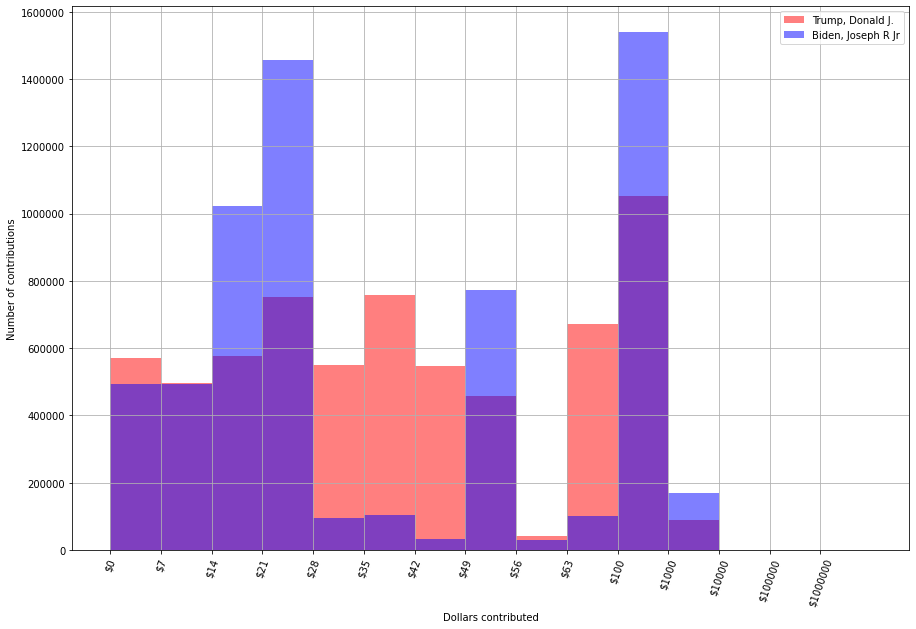

In [5]:
# Do you want to output (dataframes and plots) to be displayed?
AS_JUPYTER = True
trump = 'Trump, Donald J.'
biden = 'Biden, Joseph R Jr'
labels_dict = {'bins_b':0, 'bins_t':1, 'counts_b':2, 'counts_t':3}

def plot(bins, counts):
    """plot - Used to generate a histogram of the candidate data based on the precomputed bins(amounts) and counts of contributions.
    :param bins: Dictionary of the candidates bins (used as the x axis for our plot). Keys are the candidate 
                    name as in the dataframe.
    :param counts: Dictionary of counts corresponding to our data for each candidate. Keys are the candidate 
                    name as in the dataframe. (Used as the y axis for our plot).
    :return: None.
    """
    import matplotlib.pyplot as plt
    colors = {trump: 'red', biden: 'blue'}
    
    plt.figure(figsize=(15,10))
    # plot each candidate
    for k in bins.keys():
        x = bins[k]
        x = ['$'+str(i) for i in x]
        y = counts[k]
      
        bar = plt.bar(x, y, width=1, color=colors[k], alpha=0.5, label=k, align='edge')
        plt.ticklabel_format(style='plain', axis='y')
        plt.xticks(rotation=70)
        plt.grid(True)
        plt.legend(loc='best')
        plt.xlabel('Dollars contributed')
        plt.ylabel('Number of contributions')

    plt.show()


if AS_JUPYTER:
    import pandas as pd
    import glob
    import os
    
    # where is the "output_Q6" folder?
    data_dir = "."
    
    # create the path on a different platform
    csv_files = glob.glob(os.path.join(data_dir, "output_Q6", "*.csv"))

    print("6. Produce a histogram of the donations for the Trump and Biden campaign? The x-axis the"+\
            "amount of the donation and the y-axis the number of donors that gave that amount.")
    
    # read the csv files to get counts and amounts from the pyspark files
    hist_list = []
    for file in csv_files:
        if os.stat(file).st_size == 0:
            continue
        partial_df = pd.read_csv(file, index_col=0, header=None)
        hist_list.append(partial_df)
    
    # format them into a single dataframe we can easily index
    hist_df = pd.concat(hist_list, axis=0)
    labels_dict_inv = {value: key for key, value in labels_dict.items()}
    hist_df.rename(index=labels_dict_inv, inplace=True)
    
    # convert the bins to lists
    bins_b = hist_df.loc['bins_b'].tolist()
    bins_t = hist_df.loc['bins_t'].tolist()
    bins_dict = {trump: bins_t, biden: bins_b}
    
    # convert the counts to lists
    counts_b = hist_df.loc['counts_b'].tolist()
    counts_t = hist_df.loc['counts_t'].tolist()
    counts_dict = {trump: counts_t, biden: counts_b}
    
    plot(bins_dict, counts_dict)